In [ ]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import matplotlib.pyplot as plt

In [ ]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

In [ ]:
# Download data
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
combined_data = pd.DataFrame({
    'Date': data.index,
    'TSLA': data['TSLA']['Adj Close'],
    'BND': data['BND']['Adj Close'],
    'SPY': data['SPY']['Adj Close']
})
combined_data.set_index('Date', inplace=True)
combined_data.dropna(inplace=True)

[*********************100%***********************]  3 of 3 completed


In [ ]:
# Step 2: Forecasting Models
train_size = int(0.8 * len(combined_data))
train = combined_data.iloc[:train_size]
test = combined_data.iloc[train_size:]

In [ ]:
# Function to train and forecast with ARIMA
def train_arima(train_series, test_series, order=(1, 1, 1)):
    model = ARIMA(train_series, order=order).fit()
    forecast = model.forecast(steps=len(test_series))
    rmse = sqrt(mean_squared_error(test_series, forecast))
    mape = mean_absolute_percentage_error(test_series, forecast)
    return forecast, rmse, mape

In [ ]:
# Function to train and forecast with Exponential Smoothing
def train_exponential_smoothing(train_series, test_series):
    model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=12).fit()
    forecast = model.forecast(steps=len(test_series))
    rmse = sqrt(mean_squared_error(test_series, forecast))
    mape = mean_absolute_percentage_error(test_series, forecast)
    return forecast, rmse, mape

In [ ]:
# Function to train and forecast with Prophet
def train_prophet(train_df, test_series):
    prophet_df = train_df.reset_index().rename(columns={'Date': 'ds', train_df.columns[0]: 'y'})
    # Remove timezone information from the 'ds' column
    prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)
    model = Prophet()
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods=len(test_series), freq='D')
    forecast = model.predict(future)
    rmse = sqrt(mean_squared_error(test_series, forecast['yhat'][-len(test_series):]))
    mape = mean_absolute_percentage_error(test_series, forecast['yhat'][-len(test_series):])
    return forecast['yhat'][-len(test_series):], rmse, mape

In [ ]:
# Display results
print("ARIMA RMSE:", arima_rmse, "| MAPE:", arima_mape)
print("Exponential Smoothing RMSE:", es_rmse, "| MAPE:", es_mape)
print("Prophet RMSE:", prophet_rmse, "| MAPE:", prophet_mape)

ARIMA RMSE: 48.91160542251267 | MAPE: 0.175456595717518
Exponential Smoothing RMSE: 38.31842364630261 | MAPE: 0.1517851677274088
Prophet RMSE: 114.93766581330182 | MAPE: 0.5735212998482818


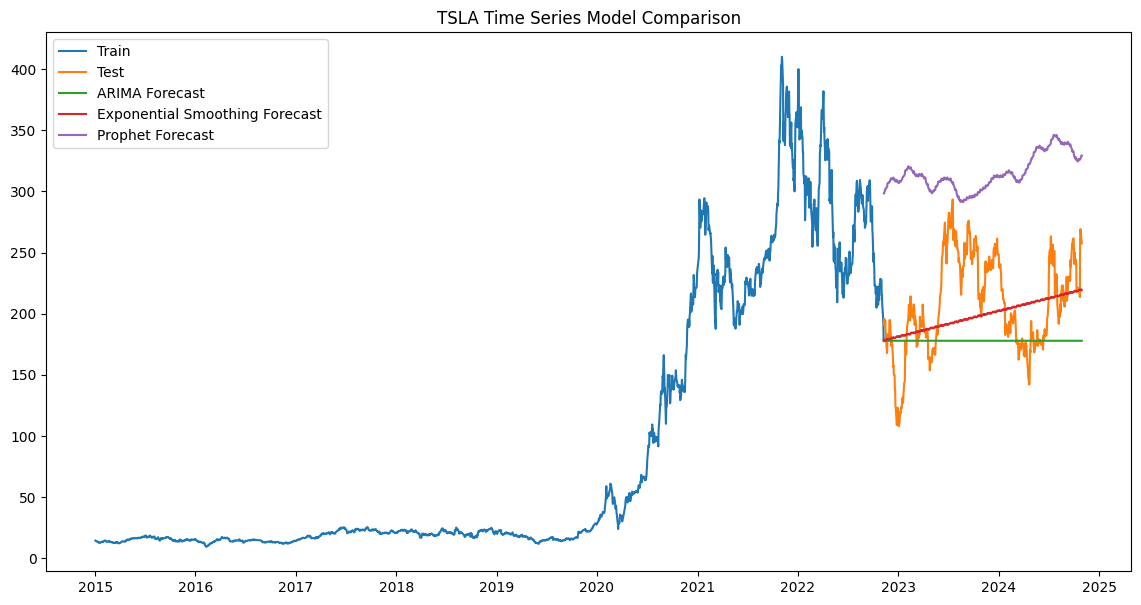

In [ ]:
# Step 3: Plotting results for visualization
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['TSLA'], label='Train')
plt.plot(test.index, test['TSLA'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, es_forecast, label='Exponential Smoothing Forecast')
plt.plot(test.index, prophet_forecast, label='Prophet Forecast')
plt.legend(loc='upper left')
plt.title('TSLA Time Series Model Comparison')
plt.show()

In [ ]:
# Step 4: Portfolio Optimization (Basic Example)
daily_returns = combined_data.pct_change().dropna()
mean_daily_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

In [ ]:
# Simulate portfolio weights and returns
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio


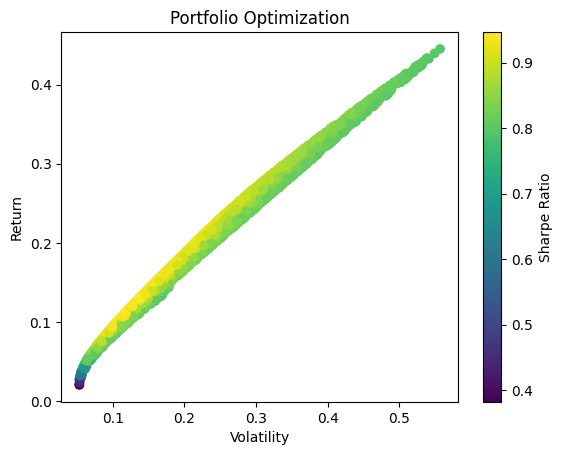

In [ ]:
# Plotting the portfolio simulations
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Portfolio Optimization')
plt.show()